
# Laboratorio: Convoluciones 1D

In [1]:
# === Configuración del entorno ===
import torch, torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request, os

def imshow_np(img, title=None, cmap=None, figsize=(5,5), vmin=0, vmax=1):
    plt.figure(figsize=figsize)
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or 'gray', vmin=vmin, vmax=vmax)
    else:
        plt.imshow(img)
    if title: plt.title(title)
    plt.axis('off')
    plt.show()

def pil_to_tensor_gray01(pil_img):
    # Convierte PIL RGB/Grayscale a tensor 1x1xH xW en [0,1]
    arr = np.array(pil_img)  # HxWxC or HxW
    if arr.ndim == 3 and arr.shape[2] == 3:
        # Conversión RGB -> gris perceptual
        r,g,b = arr[...,0], arr[...,1], arr[...,2]
        gray = 0.299*r + 0.587*g + 0.114*b
    elif arr.ndim == 2:
        gray = arr.astype(np.float32)
    else:
        raise ValueError("Formato de imagen no esperado.")
    gray = (gray / 255.0).astype(np.float32)
    t = torch.from_numpy(gray).unsqueeze(0).unsqueeze(0)  # 1x1xH xW
    return t

def tensor01_to_np(t):
    return t.detach().cpu().clamp(0,1).squeeze(0).squeeze(0).numpy()

print("PyTorch:", torch.__version__)


PyTorch: 2.8.0+cu126



## 1) Adquisición de imagen
Descargaremos una imagen pública con `urllib` (puedes reemplazar la URL). Trabajaremos en **escala de grises**.


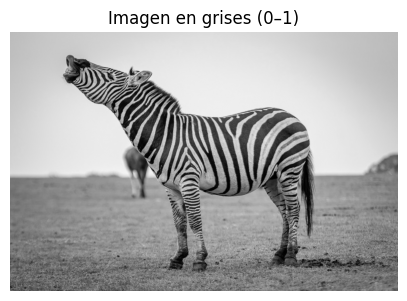

In [2]:
url = "https://www.np-brijuni.hr/imagecache/maxsize/6f67e492-4a50-4136-93fd-89f06287a549/28-01-2025/np_brijuni_47_1.jpg"
local_path = "sample.jpg"
urllib.request.urlretrieve(url, local_path)

img_rgb = Image.open(local_path).convert("RGB")
gray_t = pil_to_tensor_gray01(img_rgb)   # 1x1xH xW, en [0,1]

imshow_np(tensor01_to_np(gray_t), "Imagen en grises (0–1)")


## 2) Teoría: Convolución 1D discreta
Sea una señal discreta $f[n]$ (p.ej., una **fila** de una imagen) y un kernel $h[k]$ de soporte finito $k\in\{-m,\dots,m\}$. La **convolución 1D** se define como
$$
(f*h)[n] = \sum_{k=-m}^{m} f[n-k] \; h[k].
$$
En imágenes 2D, si un filtro es **separable** $H(x,y)=h_x(x)\,h_y(y)$, entonces la convolución 2D puede implementarse como **dos** convoluciones 1D: primero por **X** (filas) y luego por **Y** (columnas). Esto reduce el coste de $O(N K^2)$ a $O(N\,2K)$ (para un kernel $K\times K$ y $N$ píxeles).

**Propiedades clave:** linealidad, conmutatividad y asociatividad. Los **modos de borde** (relleno con ceros, reflejo, réplica) afectan los resultados cerca de los extremos.



### 2.1 Utilidades: convolución 1D separable con PyTorch
Usaremos `F.conv2d` con kernels de forma `(1,1,1,k)` (X) o `(1,1,k,1)` (Y), y `F.pad` para controlar el borde.


In [3]:

def sep_conv1d_x(inp, k1d, pad_mode='reflect'):
    """Aplica 1D en eje X (horizontal). inp: (1,1,H,W). k1d: (k,)"""
    k = k1d.view(1, 1, 1, -1)  # 1x1x1xk
    r = (k.shape[-1] - 1) // 2
    x = F.pad(inp, (r, r, 0, 0), mode=pad_mode)
    return F.conv2d(x, k)

def sep_conv1d_y(inp, k1d, pad_mode='reflect'):
    """Aplica 1D en eje Y (vertical). inp: (1,1,H,W). k1d: (k,)"""
    k = k1d.view(1, 1, -1, 1)  # 1x1xkx1
    r = (k.shape[-2] - 1) // 2
    x = F.pad(inp, (0, 0, r, r), mode=pad_mode)
    return F.conv2d(x, k)

def sep_conv2d(inp, kx, ky, pad_mode='reflect'):
    """Aplica kernel separable: primero X con kx, luego Y con ky."""
    out_x = sep_conv1d_x(inp, kx, pad_mode=pad_mode)
    out_xy = sep_conv1d_y(out_x, ky, pad_mode=pad_mode)
    return out_xy

def normalize_kernel_1d(k):
    k = k.clone().float()
    s = k.sum()
    return k / s if s != 0 else k

def rescale01(t):
    x = t.detach().cpu()
    x = x - x.min()
    return (x / (x.max() + 1e-8)).clamp(0,1)



## 3) Ejemplo 1 — Media móvil (caja) 1D
La **media móvil** promedia un vecindario de longitud impar $k$ y atenúa ruido pero suaviza bordes:

$$
h[i] = \frac{1}{k}, \quad i = -r,\dots,r,\; r=\tfrac{k-1}{2}.
$$

Aplicamos el kernel en **X** y **Y** para obtener un blur separable $k\times k$.


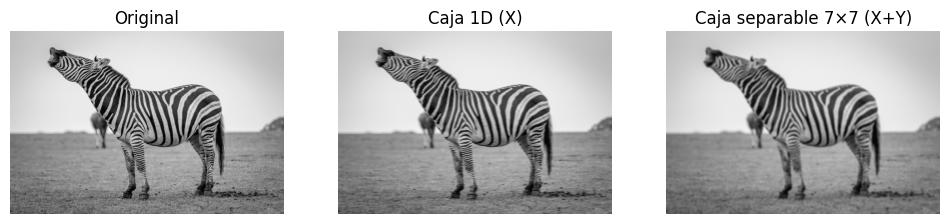

In [4]:

k = 7
box = torch.ones(k, dtype=torch.float32) / k

blur_x = sep_conv1d_x(gray_t, box, pad_mode='reflect')
blur_xy = sep_conv2d(gray_t, box, box, pad_mode='reflect')

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(tensor01_to_np(gray_t), cmap='gray', vmin=0, vmax=1); plt.title("Original"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(tensor01_to_np(blur_x), cmap='gray', vmin=0, vmax=1); plt.title("Caja 1D (X)"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(tensor01_to_np(blur_xy), cmap='gray', vmin=0, vmax=1); plt.title("Caja separable 7×7 (X+Y)"); plt.axis('off')
plt.show()



## 4) Ejemplo 2 — Derivada central 1D (bordes)
La derivada central aproximada:

$$
h = \tfrac{1}{2}[-1,\;0,\;1]
$$

- Deriva en **X** (bordes verticales) y en **Y** (bordes horizontales).
- La **magnitud** del gradiente: $\sqrt{g_x^2 + g_y^2}$.


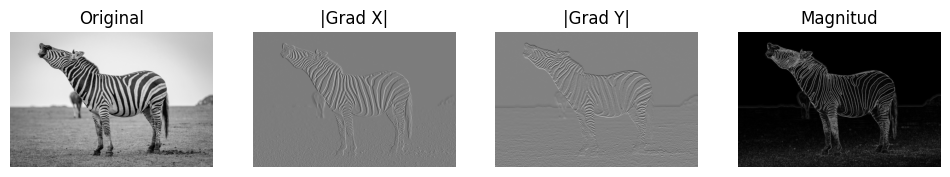

In [5]:

dx = torch.tensor([-0.5, 0.0, 0.5], dtype=torch.float32)

gx = sep_conv1d_x(gray_t, dx, pad_mode='reflect')
gy = sep_conv1d_y(gray_t, dx, pad_mode='reflect')
mag = torch.sqrt(gx**2 + gy**2)

gx_v = rescale01(gx); gy_v = rescale01(gy); mag_v = rescale01(mag)

plt.figure(figsize=(12,4))
plt.subplot(1,4,1); plt.imshow(tensor01_to_np(gray_t), cmap='gray', vmin=0, vmax=1); plt.title("Original"); plt.axis('off')
plt.subplot(1,4,2); plt.imshow(tensor01_to_np(gx_v), cmap='gray', vmin=0, vmax=1); plt.title("|Grad X|"); plt.axis('off')
plt.subplot(1,4,3); plt.imshow(tensor01_to_np(gy_v), cmap='gray', vmin=0, vmax=1); plt.title("|Grad Y|"); plt.axis('off')
plt.subplot(1,4,4); plt.imshow(tensor01_to_np(mag_v), cmap='gray', vmin=0, vmax=1); plt.title("Magnitud"); plt.axis('off')
plt.show()



## 5) Ejemplo 3 — Gaussiano 1D truncado (separable)
El **gaussiano** continuo se trunca a una ventana impar $k$ y se **normaliza** para preservar el nivel medio (DC):

$$
g[i] \propto e^{-\frac{i^2}{2\sigma^2}}, \quad i=-r,\dots,r, \; g \leftarrow \frac{g}{\sum_i g}.
$$

Aplicación separable: primero **X** y luego **Y**.


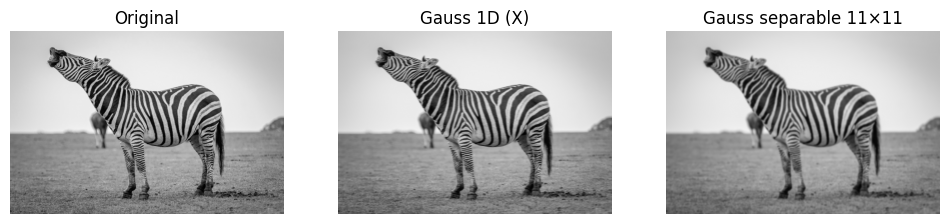

In [6]:

def gaussian1d_torch(ksize=11, sigma=2.0):
    assert ksize % 2 == 1, "ksize debe ser impar"
    r = ksize // 2
    x = torch.arange(-r, r+1, dtype=torch.float32)
    g = torch.exp(-(x**2) / (2*sigma**2))
    g = g / g.sum()
    return g

g1d = gaussian1d_torch(ksize=11, sigma=2.0)

gauss_x = sep_conv1d_x(gray_t, g1d, pad_mode='reflect')
gauss_xy = sep_conv2d(gray_t, g1d, g1d, pad_mode='reflect')

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(tensor01_to_np(gray_t), cmap='gray', vmin=0, vmax=1); plt.title("Original"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(tensor01_to_np(gauss_x), cmap='gray', vmin=0, vmax=1); plt.title("Gauss 1D (X)"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(tensor01_to_np(gauss_xy), cmap='gray', vmin=0, vmax=1); plt.title("Gauss separable 11×11"); plt.axis('off')
plt.show()



## 6) Unsharp Mask separable (realce de nitidez)
Pasos:
1. Suaviza con **gaussiano 1D+1D** para obtener $I_{suave}$.
2. Calcula **detalle**: $D = I - I_{suave}$.
3. Reintegra: $I' = I + \alpha D$ (recorte a [0,1]).


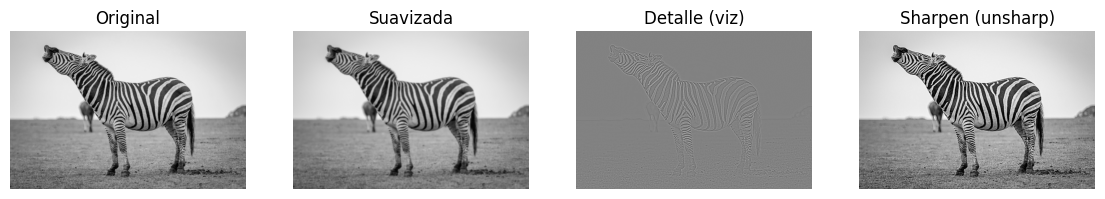

In [7]:

def unsharp_separable(inp, ksize=9, sigma=1.5, amount=1.2):
    g = gaussian1d_torch(ksize, sigma)
    blur = sep_conv2d(inp, g, g, pad_mode='reflect')
    detail = inp - blur
    sharp = (inp + amount * detail).clamp(0,1)
    return sharp, blur, detail

sharp, blur, detail = unsharp_separable(gray_t, ksize=9, sigma=1.5, amount=1.4)

plt.figure(figsize=(14,4))
plt.subplot(1,4,1); plt.imshow(tensor01_to_np(gray_t), cmap='gray', vmin=0, vmax=1); plt.title("Original"); plt.axis('off')
plt.subplot(1,4,2); plt.imshow(tensor01_to_np(blur), cmap='gray', vmin=0, vmax=1); plt.title("Suavizada"); plt.axis('off')
plt.subplot(1,4,3); plt.imshow(tensor01_to_np(rescale01(detail)), cmap='gray', vmin=0, vmax=1); plt.title("Detalle (viz)"); plt.axis('off')
plt.subplot(1,4,4); plt.imshow(tensor01_to_np(sharp), cmap='gray', vmin=0, vmax=1); plt.title("Sharpen (unsharp)"); plt.axis('off')
plt.show()



## 7) Modos de borde
Compara `reflect`, `replicate` y `constant` al aplicar caja 1D separable. Observa artefactos en las zonas cercanas al límite.


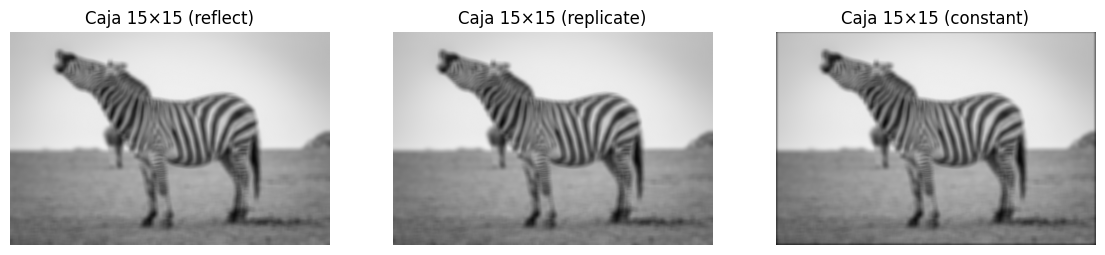

In [8]:

k = 15
box = torch.ones(k, dtype=torch.float32) / k
modes = ['reflect', 'replicate', 'constant']
outs = []
for md in modes:
    out = sep_conv2d(gray_t, box, box, pad_mode=md)
    outs.append(out)

plt.figure(figsize=(14,4))
for i,(md,out) in enumerate(zip(modes, outs), start=1):
    plt.subplot(1,3,i); plt.imshow(tensor01_to_np(out), cmap='gray', vmin=0, vmax=1)
    plt.title(f"Caja {k}×{k} ({md})"); plt.axis('off')
plt.show()



## 8) Actividades
- **A (10 min):** prueba caja con $k\in\{5,9,15\}$ (separable) y comenta nitidez vs. ruido.  
- **B (10 min):** genera gaussianos con $\sigma\in\{1.0,2.5\}$ y $k\in\{7,11\}$; compara con caja del mismo $k$.  
- **C (15 min):** usa una **derivada más ancha** (p.ej., $[-1,-2,0,2,1]/8$) y compara mapas de bordes con la derivada central.  
- **D (15 min):** ajusta `amount` en unsharp (0.5, 1.0, 2.0) y detecta cuándo aparecen halos.  
- **E (10 min):** repite (A) con distintos **modos de borde** y captura artefactos en los extremos.
